# A primer on mechanistic inference with differentiable process-based

models in Julia

Here you will learn about different techniques to infer parameters of a
(differentiable) process-based model against data. This is useful to in
the context of mechanistic inference, where we want to explain patterns
in a system by understanding the processes that generate them, in
contrast to purely statistical or empirical inference, which might
identify patterns or correlations in data without necessarily
understanding the causes. We’ll mostly focus on differential equation
models. Make sure that you stick to the end, where we’ll see how we can
not only infer parameter values but also functional forms, by
parametrizing models’ components with neural networks.

# Preliminaries

## Wait, what is a differentiable model?

One can usually write a model as a map $\mathcal{M}$ mapping some
parameters $p$, an initial state $u_0$ and a time $t$ to a future state
$u_t$

$$u_t = \mathcal{M}(u_0, t, p).$$

We call **differentiable** a model $\mathcal{M}$ for which we can
calculate its derivative with respect to $p$ or $u_0$. The derivative
$\frac{\partial \mathcal{M}}{\partial \theta}$ expresses how much the
model output changes with respect to a small change in $\theta$.

> **Recall your Calculus class!**
>
> $$\frac{df}{dx}(x) = \lim_{h \to 0} \frac{f(x + h) - f(x)}{h}$$

Let’s illustrate this concept with the [logistic equation
model](https://en.wikipedia.org/wiki/Logistic_function#In_ecology:_modeling_population_growth).
This model has an analytic formulation given by:

$$\mathcal{M}(u_0, p, t) = \frac{K}{1 + \big( \frac{K-u_0}{u_0} \big) e^{rt}}$$

Let’s code it


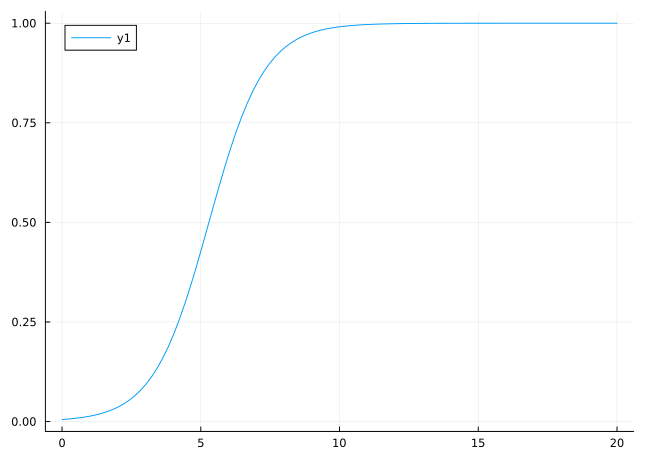

In [2]:
using UnPack
using Plots
using Random
using ComponentArrays
using BenchmarkTools
Random.seed!(0)

function mymodel(u0, p, t)
    T = eltype(u0)
    @unpack r, K = p

    @. K / (one(T) + (K - u0) / u0 * exp(-r * t))
end

p = ComponentArray(;r = 1., K = 1.)
u0 = 0.005

tsteps = range(0, 20, length=100)
y = mymodel(u0, p, tsteps)

plot(tsteps, y)

> **What is a `ComponentArray`?**
>
> A `ComponentArray` is a convenient Array type that allows to access
> array elements with symbols, similarly to a `NamedTuple`, while
> behaving like a standard array. For instance, you could do something
> like
>
> ``` julia
> cv = ComponentVector(;a = 1, b = 2)
> cv .= [3, 4]
> ```
>
> <pre>ComponentVector{Int64}(a = 3, b = 4)</pre>
>
> This is useful, because you can only calculate a gradient w.r.t a
> `Vector`!

Now let’s try to calculate the gradient of this model. While you could
in this case derive the gradient analytically, an analytic derivation is
generally tricky with complex models. And what about models that can
only be simulated numerically, with no analytic expressions? We need to
find a more automatized way to calculate gradients.

How about [the finite difference
method](https://en.wikipedia.org/wiki/Finite_difference_method)?

> **Exercise: finite differences**
>
> Implement the function `∂mymodel_∂K(h, u0, p, t)` which returns the
> model’s derivative with respect to `K`, calculated with a small `h` to
> be provided by the user.
>
> > **Solution**
> >
> > ``` julia
> > #...
> > ```

The gradient of the model is useful to understand how a parameter
influences the output of the model. Let’s calculate the importance of
the carrying capacity `K` on the model output:


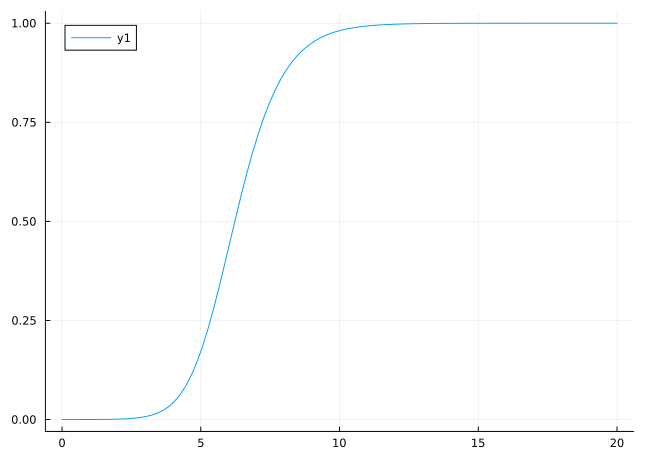

In [6]:
dm_dp = ∂mymodel_∂K(1e-1, u0, p, tsteps)
plot(tsteps, dm_dp)

As you can observe, the carrying capacity has no effect at small $t$
where population is small, and its influence on the dynamics grows as
the population grows. We expect the reverse effect for $r$.

## On the importance of gradients for inference

The ability to calculate the derivative of a model is crucial when it
comes to inference. Both within a full Bayesian inference context, where
one wants to sample the posterior distribution of parameters $\theta$
given data $u$, $p(\theta| u)$, or when one wants to obtain a point
estimate $\theta^\star = \argmax_\theta (p(\theta | u))$ (frequentist or
machine learning context), the model gradient proves very useful. In a
full Bayesian inference context, they are used e.g. with Hamiltonian
Markov Chains methods, such as the NUTS sampler, and in a machine
learning context, they are used with gradient-based optimizer.

### Gradient descent

The best way to grasp the importance of gradients in inference is to
understand the [gradient descent
algorithm](https://en.wikipedia.org/wiki/Gradient_descent).

The following picture illustrates the algorithm in the special case
where $p$ is one-dimensional.

![](https://editor.analyticsvidhya.com/uploads/631731_P7z2BKhd0R-9uyn9ThDasA.png)

Given an initial estimate of the parameter value $p_0$,
$\frac{d \mathcal{M}}{dp}$ is used to suggest a new, better estimate,
following

$$p_{n+1} = p_n - \eta \frac{d \mathcal{M}}{dp}(u_0, t, p) $$

where $\eta$ is the learning rate.

Gradient-based methods are usually very efficient in high-dimensional
spaces.

## Automatic differentiation

Let’s go back to our method `∂mymodel_∂p`. What is the optimal value of
`h` to calculate the derivative? This is a tricky question, because a
too small `h` can lead to round off errors ([see more explanations
here](https://book.sciml.ai/notes/08-Forward-Mode_Automatic_Differentiation_(AD)_via_High_Dimensional_Algebras/))
while `h` too large also leads to a bad approximation of the asymptotic
definition.

Fortunately, a bunch of techniques referred to as [**automatic
differentiation**](https://en.wikipedia.org/wiki/Automatic_differentiation)
(AD) allows to **exactly** differentiate any piece of numerical
functions. In practice, your code must be exclusively written within an
AD-backend, such as Torch, JAX or Tensorflow. Those libraries do not
know how to differentiate code not written in their own language, such
as normal Python code.

Fortunately, Julia is an *AD-pervasive language*! This means that any
piece of Julia code is theoretically differentiable with AD.

In [7]:
using ForwardDiff

@btime ForwardDiff.gradient(p -> mymodel(u0, p, 1.), p);

  1.225 μs (12 allocations: 432 bytes)

This is what makes Julia great for model calibration and inference!
Write your model in Julia, and any inference method using AD will be
able to work with your model!

To learn more about AD in Julia, check-out this [cool
blog-post](https://gdalle.github.io/AutodiffTutorial/) and [this short
presentation](https://gdalle.github.io/JuliaCon2024-AutoDiff/#/title-slide).

Now let’s get started with inference.

# Mechanistic inference

## The mechanistic model and the data

We’ll use a simple dynamical community model, the [Lotka
Volterra](https://en.wikipedia.org/wiki/Lotka–Volterra_equations) model,
to generate data. We’ll then contaminate this data with noise, and try
to recover the parameters that have generated the data. The goal of the
session will be to estimate those parameters from the data, using a
bunch of different techniques.

So let’s first generate the data.


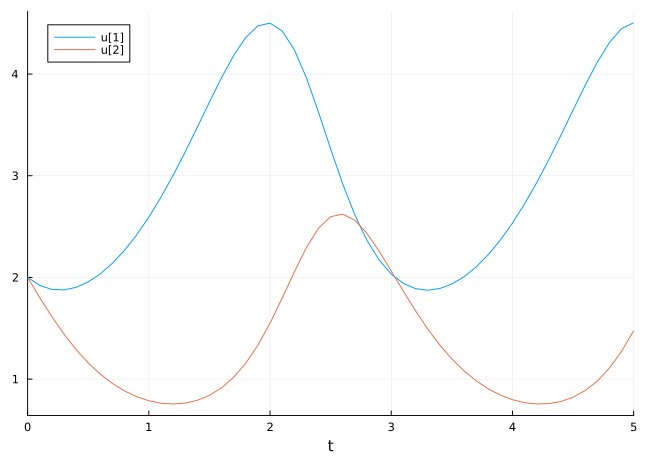

In [8]:
using OrdinaryDiffEq

# Define Lotka-Volterra model.
function lotka_volterra(du, u, p, t)
    # Model parameters.
    @unpack α, β, γ, δ = p
    # Current state.
    x, y = u

    # Evaluate differential equations.
    du[1] = (α - β * y) * x # prey
    du[2] = (δ * x - γ) * y # predator

    return nothing
end

# Define initial-value problem.
u0 = [2.0, 2.0]
p_true = (;α = 1.5, β = 1.0, γ = 3.0, δ = 1.0)
# tspan = (hudson_bay_data[1,:t], hudson_bay_data[end,:t])
tspan = (0., 5.)
tsteps = range(tspan[1], tspan[end], 51)
alg = Tsit5()

prob = ODEProblem(lotka_volterra, u0, tspan, p_true)

saveat = tsteps
sol_true = solve(prob, alg; saveat)
# Plot simulation.
plot(sol_true)

This is the true state of the system. Now let’s contaminate it with
observational noise.

> **Exercise: contaminate data with noise**
>
> Create a `data_mat` array, which consists of the ODE solution
> contaminated with a lognormally-distributed noise with standard
> deviation `0.3`.
>
> > **Note**
> >
> > Note that we add lognormally-distributed noise instead of
> > normally-distributed because we are observing population abundance,
> > which can only be positive.
>
> > **Solution**
> >
> > ``` julia
> > # data_mat = ...
> > ```

Now that we have our data, let’s do some inference!

## Mechanistic inference as a supervised learning task

We’ll get started with a very crude approach to inference, where we’ll
treat the calibration of our LV model similarly to a supervised machine
learning task. To do so, we’ll write a loss function, defining a
distance between our model and the data, and we’ll try to minimize this
loss. The parameter minimizing this loss will be our best model
parameter estimate.

In [11]:
function loss(p)
    predicted = solve(prob,
                        alg; 
                        p, 
                        saveat,
                        abstol=1e-6, 
                        reltol = 1e-6)

    l = 0.
    for i in 1:length(predicted)
        if all(predicted[i] .> 0)
            l += sum(abs2, log.(data_mat[:, i]) - log.(predicted[i]))
        end
    end
    return l, predicted
end

loss (generic function with 1 method)

> **Note**
>
> Notice that we explicitly check whether predictions are \> 0, because
> the log of negative number is not defined and will throw an error!

Let’s define a helper function, that will plot how good does the model
perform across different iterations.

In [12]:
losses = []
callback = function (p, l, pred; doplot=true)
    push!(losses, l)
    if length(losses)%100==1
        println("Current loss after $(length(losses)) iterations: $(losses[end])")
        if doplot
            plt = scatter(tsteps, data_mat',  color = [1 2], label=["Prey abundance data" "Predator abundance data"])
            plot!(plt, tsteps, pred', color = [1 2], label=["Inferred prey abundance" "Inferred predator abundance"])
            display(plot(plt, yaxis = :log10, title="it. : $(length(losses))"))
        end
    end
    return false
end

#13 (generic function with 1 method)

And let’s define a wrong initial guess for the parameters

Current loss after 1 iterations: 251.10349846646116


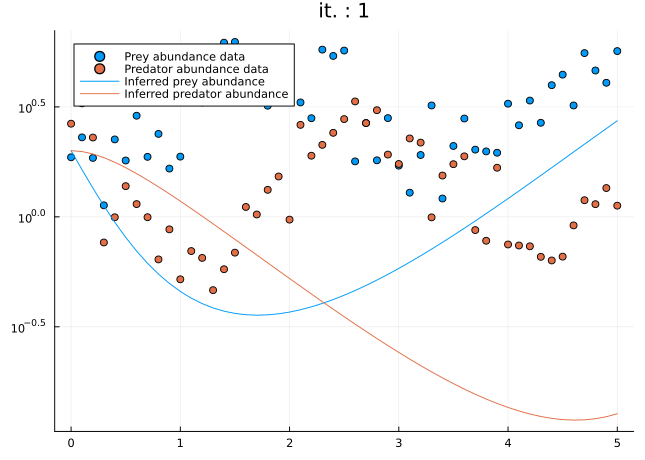

false

In [13]:
pinit = ComponentArray(;α = 1., β = 1.5, γ = 1.0, δ = 0.5)

callback(pinit, loss(pinit)...; doplot = true)

Our initial predictions are bad, but you’ll likely get even worse
predictions in a real-case scenario!

We’ll use the library `Optimization`, which is a wrapper library around
many optimization libraries in Julia. `Optimization` therefore provides
us with many different types of optimizers to find parameters minimizing
`loss`. We’ll specifically use the infamous [Adam
optimizer](https://arxiv.org/abs/1412.6980) (187k citations!!!), widely
used in ML.

Current loss after 101 iterations: 8.039887486778179


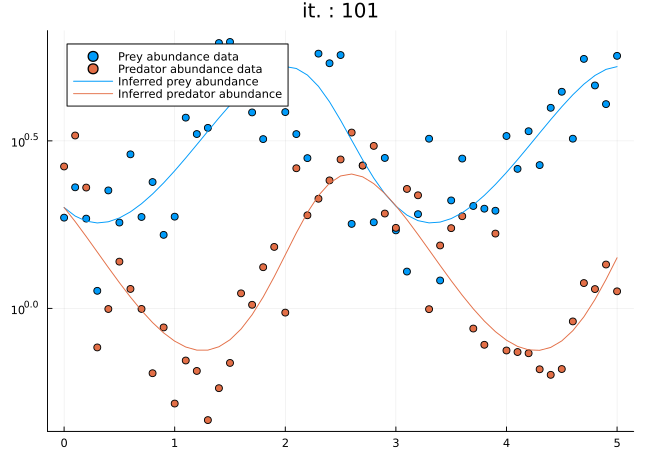

Current loss after 201 iterations: 7.9094080306025445


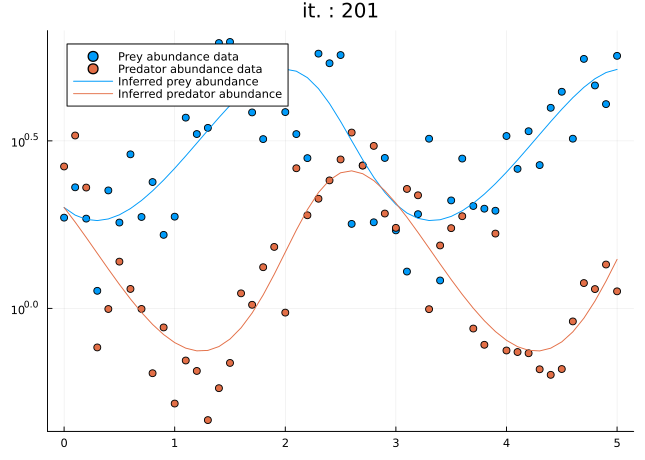

Current loss after 301 iterations: 7.806219868794404


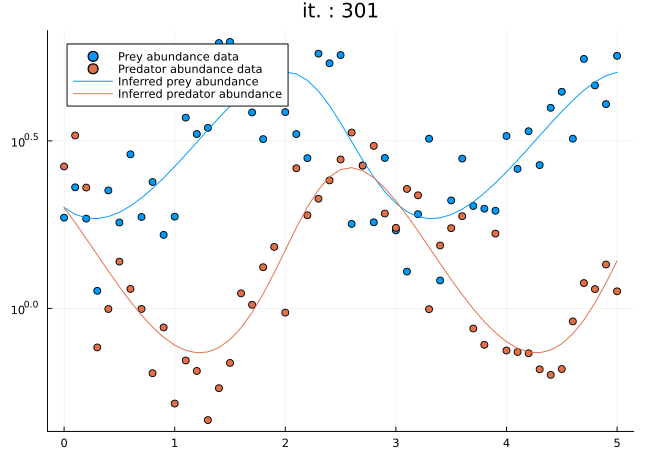

Current loss after 401 iterations: 7.74345616951535


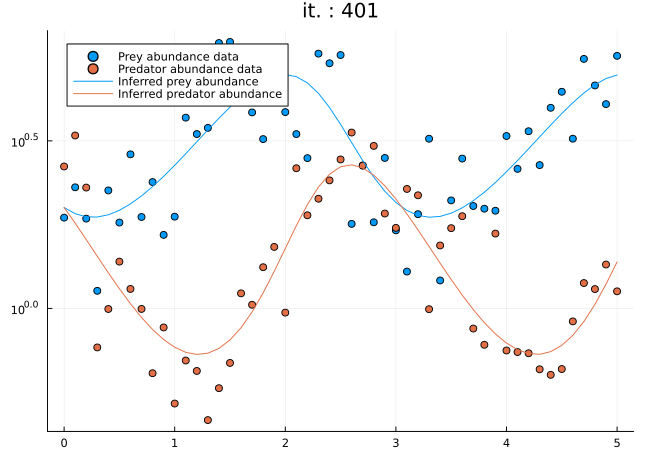

Current loss after 501 iterations: 7.712910946192632


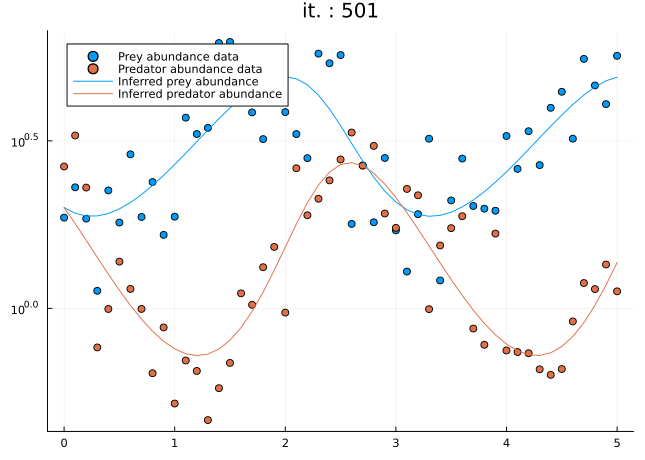

 13.731183 seconds (49.62 M allocations: 3.145 GiB, 7.17% gc time, 93.45% compilation time: 8% of which was recompilation)

ComponentVector{Float64}(α = 1.5322556800023097, β = 1.0159023620691514, γ = 2.8926590524331766, δ = 0.9148575218436299)

In [14]:
using Optimization
using OptimizationOptimisers
using SciMLSensitivity

adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction((x, p) -> loss(x), adtype)
optprob = Optimization.OptimizationProblem(optf, pinit)

@time res_ada = Optimization.solve(optprob, Adam(0.1); callback, maxiters = 500)
res_ada.minimizer

Nice! It seems that the optimizer did a reasonable job, and that we
found a reasonable estimate of our parameters!

> **Exercise: Hey, this is cheating!**
>
> Notice that we use the true `u0`, as if we were to know exactly the
> initial state. In a real situation, we need also to infer the true
> state!
>
> Can you modify the model to infer the true state?
>
> > **Solution**
> >
> > ``` julia
> > # function loss2(p)
> > #    ...
> > # end
> > # losses = []
> >
> > # pinit = ...
> >
> > # adtype = Optimization.AutoZygote()
> > # optf = Optimization.OptimizationFunction((x, p) -> loss2(x), adtype)
> > # optprob = Optimization.OptimizationProblem(optf, pinit)
> >
> > # @time res_ada = Optimization.solve(optprob, Adam(0.1); callback, maxiters = 1000)
> > # res_ada.minimizer
> > ```

## Regularization

In supervised learning, it is common practice to regularize the model to
prevent overfitting. Regularization can also help the model to converge.
Regularization is done by adding a penalty term to the loss function:

$$
\text{Loss}(\theta) = \text{Loss}_{\text{data}}(\theta) + \lambda \, \text{Reg}(\theta)
$$

> **Exercise: regularization**
>
> Add a regularization term to the loss, which penalizes the loss when
> the inferred initial conditions are less than 0.
>
> > **Solution**
> >
> > ``` julia
> > #...
> > ```

## Multiple shooting

Another trick that can greatly improve the convergence of the
optimization is to break down the prediction task into simpler tasks.
Namely, instead of trying to predict in one shot the whole time series,
the idea of multiple shooting is to predict for shorter time horizon.

> **Exercise: multiple shooting**
>
> Can you modify your loss function to implement this idea?
>
> > **Solution**
> >
> > ``` julia
> > # tsteps = sol_true.t
> >
> > # function loss_multiple_shooting(p)
> > #     length_interval = 20
> > #     K = length(tsteps) ÷ length_interval
> > #     @assert length(tsteps) % K == 1 "`length(tsteps) - 1` is not a multiple of `length_interval`"
> > #     interval_idxs = [k*length_interval+1:(k+1)*length_interval+1 for k in 0:(K-1)]
> >
> > #     l = 0.
> > #     for idx in interval_idxs
> > #         ...
> > #     end
> >
> > #     predicted = solve(prob,
> > #                     alg; 
> > #                     p,
> > #                     saveat=tsteps,
> > #                     abstol=1e-6, 
> > #                     reltol = 1e-6)
> > #     return l, predicted
> > # end
> > # losses = []
> >
> > # pinit = ComponentArray(;α = 1., β = 1.5, γ = 1.0, δ = 0.5)
> >
> > # adtype = Optimization.AutoZygote()
> > # optf = Optimization.OptimizationFunction((x, p) -> loss(x), adtype)
> > # optprob = Optimization.OptimizationProblem(optf, pinit)
> >
> > # @time res_ada = Optimization.solve(optprob, Adam(0.1); callback, maxiters = 500)
> > # res_ada.minimizer
> > ```

## Sensitivity methods

Did you wonder why do we need to load `SciMLSensitivity`? and why did we
specify `adtype = Optimization.AutoZygote()`?

AD comes in different flavours, with broadly two types of AD methods -
**forward methods** and **backward methods** -, and a bunch of different
implementations.

You can specify which ones `Optimization.jl` will use to differentiate
`loss` with `adtype`, see available options
[here](https://docs.sciml.ai/Optimization/stable/API/ad/).

But when it comes to differentiating the `solve` function from
`OrdinaryDiffEq`, you want to use `AutoZygote()`, because when trying to
differentiate `solve`, a specific adjoint rule provided by the
`SciMLSensitivity` package will be used.

> **What are adjoint rules?**
>
> These are algoirithmic rules that specify to the AD backend *how* to
> calculate the derivative of a specific function.
>
> If you want to know more, check-out the [ChainRules.jl
> documentation](https://juliadiff.org/ChainRulesCore.jl/)

These adjoint rules can be specificed by the keyword `sensealg` when
calling `solve` and have been designed for best performance when
differentiating solutions of an `ODEProblem`. There exists a lot of them
(see a review [here](https://arxiv.org/abs/2406.09699)), and if
`sensealg` is not provided, a smart polyalgorithm is going to pick up
one for you.

You can have a look in the documentation
[here](https://docs.sciml.ai/SciMLSensitivity/stable/manual/differential_equation_sensitivities/)
for hints on how to choose an algorithm.

> **Exercise: benchmarking sensitivity methods**
>
> Can you evaluate the performance of `ForwardDiffSensitivity()` and
> `ReverseDiffAdjoint()`?
>
> > **Solution**
> >
> > ``` julia
> > #...
> > ```

For a small number of parameters, forward methods tend to perform best,
but with higher number of parameters, the other way around is true.

Well done! Now, let’s jump into the Bayesian world…

## Bayesian inference

Julia has a very strong library for Bayesian inference:
[Turing.jl](https://turinglang.org).

Let’s declare our first Turing model!

This is done with the `@model` macro, which allows the library to
automatically construct the posterior distribution based on the
definition of your model’s random variables.

> **Frequentist (supervised learning) vs. Bayesian approach**
>
> The main difference between a frequentist approach and a Bayesian
> approach is that the latter considers that parameters are random
> variables. Hence instead of trying to estimate a single value for the
> parameters, the Bayesian will try to estimate the posterior (joint)
> distribution of those parameters.
>
> $$
> P(\theta | \mathcal{D}) = \frac{P(\mathcal{D} | \theta) P(\theta)}{P(\mathcal{D})}
> $$

Random variables are defined with the `~` symbol.

### Our first Turing model

In [24]:
using Turing
using LinearAlgebra

@model function fitlv(data, prob)
    # Prior distributions.
    σ ~ InverseGamma(3, 0.5)
    α ~ truncated(Normal(1.5, 0.5); lower=0.5, upper=2.5)
    β ~ truncated(Normal(1.2, 0.5); lower=0, upper=2)
    γ ~ truncated(Normal(3.0, 0.5); lower=1, upper=4)
    δ ~ truncated(Normal(1.0, 0.5); lower=0, upper=2)

    # Simulate Lotka-Volterra model. 
    p = (;α, β, γ, δ)
    predicted = solve(prob, alg; p, saveat)

    # Observations.
    for i in 1:length(predicted)
        if all(predicted[i] .> 0)
            data[:, i] ~ MvLogNormal(log.(predicted[i]), σ^2 * I)
        end
    end

    return nothing
end

fitlv (generic function with 2 methods)

Now we can instantiate our model, and run the inference!

In [25]:
model = fitlv(data_mat, prob)

# Sample 3 independent chains with forward-mode automatic differentiation (the default).
chain = sample(model, NUTS(), MCMCThreads(), 1000, 3; progress=true)

Chains MCMC chain (1000×17×3 Array{Float64, 3}):
Iterations = 501:1:1500
Number of chains = 3
Samples per chain = 1000
Wall duration = 26.64 seconds
Compute duration = 25.3 seconds
parameters = σ, α, β, γ, δ
internals = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size
Summary Statistics
 parameters mean std mcse ess_bulk ess_tail rhat ⋯
 Symbol Float64 Float64 Float64 Float64 Float64 Float64 ⋯
 σ 0.2796 0.0195 0.0005 1721.3574 1789.3390 1.0013 ⋯
 α 1.4928 0.1501 0.0052 841.9730 862.7118 1.0025 ⋯
 β 0.9902 0.1210 0.0040 907.2968 995.0953 1.0008 ⋯
 γ 2.9967 0.2656 0.0090 863.2374 992.8786 1.0045 ⋯
 δ 0.9592 0.1043 0.0034 939.4457 1141.4992 1.0034 ⋯
 1 column omitted 
Quantiles
 parameters 2.5% 25.0% 50.0% 75.0% 97.5% 
 Symbol Float64 Float64 Float64 Float64 Float64 
 σ 0.2449 0.2656 0.2788 0.2922 0.3212
 α 1.2283 1.3875 1.4784 1.5863 1.8276
 β 0.7748 0.9077 0.9816 1.0661 1.2575
 γ 2.4786 2.8192 2.9973 3.1727 3.5358
 δ 0.7563 0.8869 0.9584 1.0274 1.1650

> **Threads**
>
> How many threads do you have running? `Threads.nthreads()` will tell
> you!

Let’s see if our chains have converged.


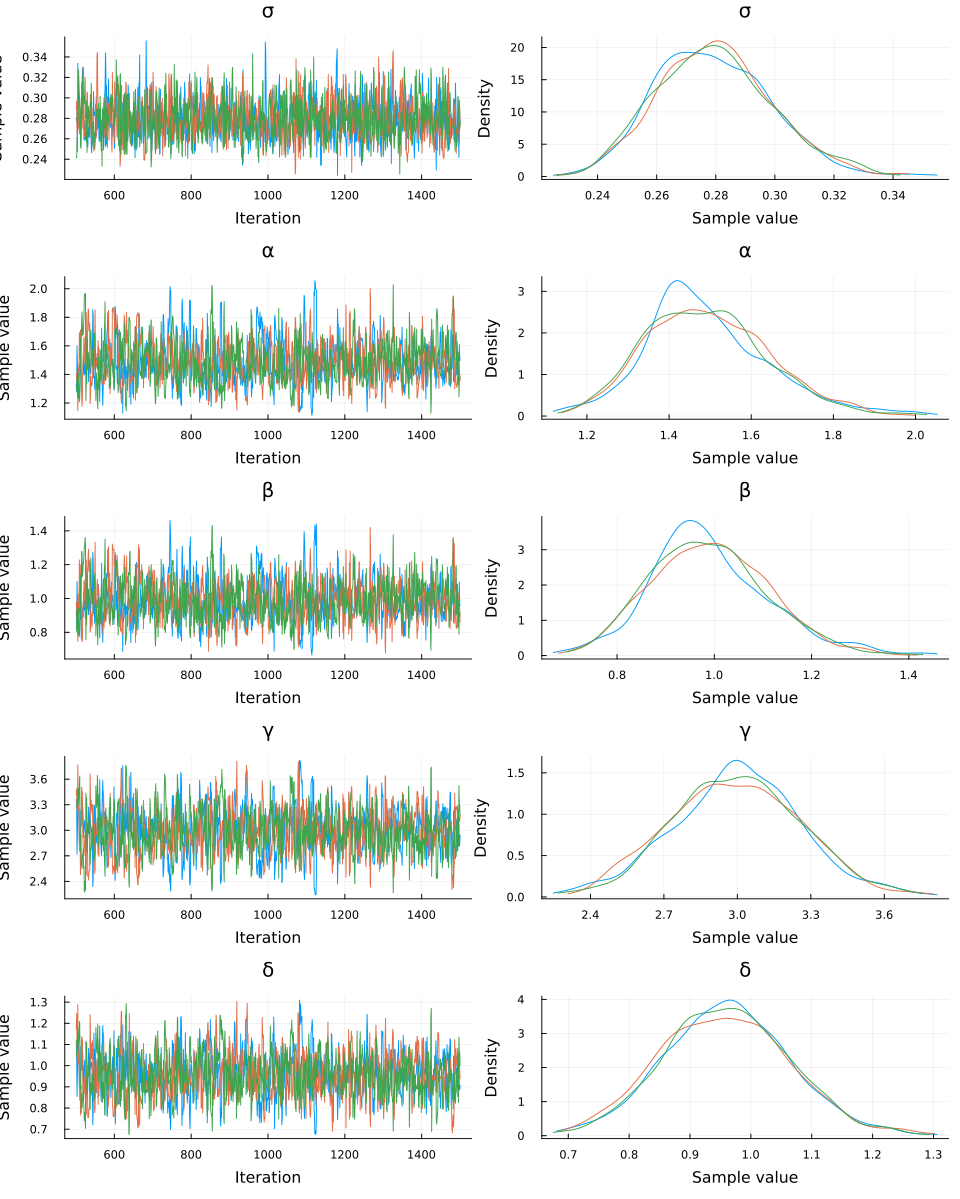

In [26]:
using StatsPlots
plot(chain)

### Data retrodiction

Let’s now generate simulated data using samples from the posterior
distribution, and compare to the original data.


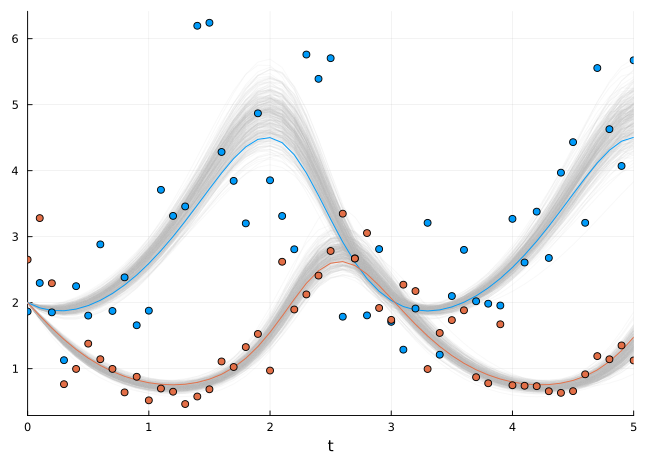

In [27]:
function plot_predictions(chain, sol, data_mat)
    myplot = plot(; legend=false)
    posterior_samples = sample(chain[[:α, :β, :γ, :δ]], 300; replace=false)
    for parr in eachrow(Array(posterior_samples))
        p = NamedTuple([:α, :β, :γ, :δ] .=> parr)
        sol_p = solve(prob, Tsit5(); p, saveat)
        plot!(sol_p; alpha=0.1, color="#BBBBBB")
    end

    # Plot simulation and noisy observations.
    plot!(sol; color=[1 2], linewidth=1)
    scatter!(sol.t, data_mat'; color=[1 2])
    return myplot
end
plot_predictions(chain, sol_true, data_mat)

> **Exercise: Hey, this is cheating!**
>
> Notice that we use the true `u0`, as if we were to know exactly the
> initial state. In a real situation, we need also to infer the true
> state!
>
> Can you modify the model to infer the true state?
>
> > **Solution**
> >
> > ``` julia
> > # @model function fitlv2(data, prob)
> > #     # Prior distributions.
> > #     σ ~ InverseGamma(2, 3)
> > #     α ~ truncated(Normal(1.5, 0.5); lower=0.5, upper=2.5)
> > #     β ~ truncated(Normal(1.2, 0.5); lower=0, upper=2)
> > #     γ ~ truncated(Normal(3.0, 0.5); lower=1, upper=4)
> > #     δ ~ truncated(Normal(1.0, 0.5); lower=0, upper=2)
> > #     u0 ~ ...
> > #     ...
> > # end
> > # ...
> > # chain2 = ...
> > ```

Here is a small utility function to visualize your results.


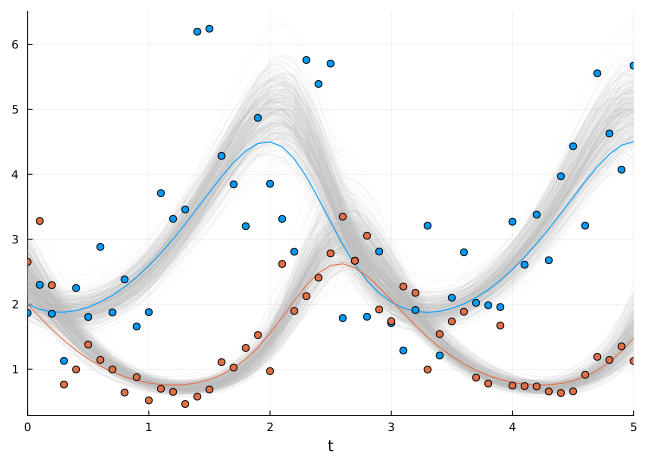

In [30]:
function plot_predictions2(chain, sol, data_mat)
    myplot = plot(; legend=false)
    posterior_samples = sample(chain, 300; replace=false)
    for i in 1:length(posterior_samples)
        ps = posterior_samples[i]
        p = get(ps, [:α, :β, :γ, :δ], flatten=true)
        u0 = get(ps, :u0, flatten = true)
        u0 = [u0[1][1], u0[2][1]]

        sol_p = solve(prob, Tsit5(); u0, p, saveat)
        plot!(sol_p; alpha=0.1, color="#BBBBBB")
    end

    # Plot simulation and noisy observations.
    plot!(sol; color=[1 2], linewidth=1)
    scatter!(sol.t, data_mat'; color=[1 2])
    return myplot
end

plot_predictions2(chain2, sol_true, data_mat)

### Mode estimation

Turing allows you to find the maximum likelihood estimate (MLE) or
maximum a posteriori estimate (MAP).

$$
\theta_{MLE} = \underset{\theta}{\text{argmax}} \, P(\mathcal{D} | \theta), \qquad \theta_{MAP} = \underset{\theta}{\text{argmax}} \, P(\theta | \mathcal{D}).
$$

> **MAP and regularization in supervised learning**
>
> Although Bayesian inference seems very different from the supervised
> learning approach we developed in the first part, estimating the MAP,
> which can be still considered as Bayesian inference, transforms in an
> optimization problem that can be seen as a supervised task.
>
> To see that, we can log-transform the posterior:
>
> $$
> \log P(\theta | \mathcal{D}) = \log P(\mathcal{D} | \theta) + \log P(\theta) - \log P(\mathcal{D})
> $$
>
> Since the evidence $P(\mathcal{D})$ is independent of $\theta$, it can
> be ignored when maximizing with respect to $\theta$. Therefore, the
> MAP estimate simplifies to:
>
> $$
> \theta_{MAP} = \underset{\theta}{\text{argmax}} \, \left[\log P(\mathcal{D} | \theta) + \log P(\theta)\right]
> $$
>
> Here, $\log P(\mathcal{D}| \theta)$ can be seen as our previous
> non-regularized `loss` and $\log P(\theta)$ acts as a regularization
> term, penalizing unlikely parameter values based on our prior beliefs.
> Priors on parameters can be seen as regularization term.

MLE and MAP can be obtained by `maximum_likelihood` and
`maximum_a_posteriori`.

In [31]:
Random.seed!(0)
maximum_a_posteriori(model2, maxiters = 1000)

ModeResult with maximized lp of -104.88
[0.3545376205457767, 1.4695692517420373, 0.9162499950736273, 3.263944963496157, 1.0243607922108577, 2.150749205538098, 2.4795481828054595]

Since `Turing` uses under the hood the same Optimization.jl library, you
can specify which optimizer youd’d like to use.

In [32]:
map_res = maximum_a_posteriori(model2, Adam(0.01), maxiters=2000)

ModeResult with maximized lp of -104.88
[0.35455374965749115, 1.4707686527453756, 0.9171941147556801, 3.2614628620071664, 1.0235193248242322, 2.1506473758409883, 2.4789084651090993]

We can check whether the optimization has converged:

In [33]:
@show map_res.optim_result

map_res.optim_result = retcode: Default
u: [-1.036895323466616, -0.05847935462336067, -0.16599185850450063, 1.1190957778225292, 0.04704732580671333, 0.765768901858866, 0.9078183282523818]
Final objective value:     104.87762402604213


retcode: Default
u: 7-element Vector{Float64}:
 -1.036895323466616
 -0.05847935462336067
 -0.16599185850450063
  1.1190957778225292
  0.04704732580671333
  0.765768901858866
  0.9078183282523818

What’s very nice is that Turing.jl provides you with utility functions
to analyse your mode estimation results.

In [34]:
using StatsBase
coeftable(map_res)

> **Exercise: Partially observed state**
>
> Let’s assume the following situation: for some reason, you only have
> observation data for the predator. Could you still infer all
> parameters of your model, including those of the prey?
>
> Could be! Because the signal of the variation in abundance of the
> predator contains information on the dynamics of the whole
> predator-prey system.
>
> Do it!
>
> You’ll need to assume so prior state for the prey. Just assume that it
> is the same as that of the predator.
>
> > **Solution**
> >
> > ``` julia
> > # @model function fitlv3(data::AbstractVector, prob)
> > #     # Prior distributions.
> > #     σ ~ InverseGamma(2, 3)
> > #     α ~ truncated(Normal(1.5, 0.5); lower=0.5, upper=2.5)
> > #     β ~ truncated(Normal(1.2, 0.5); lower=0, upper=2)
> > #     γ ~ truncated(Normal(3.0, 0.5); lower=1, upper=4)
> > #     δ ~ truncated(Normal(1.0, 0.5); lower=0, upper=2)
> > #     u0 ~ #...MvLogNormal([data[1], data[1]], σ^2 * I)
> > #     ...
> > # end
> >
> > # model3 = fitlv3(...
> >
> > # Sample 3 independent chains.
> > # chain3 = ...
> > ```

### AD backends and `sensealg`

The `NUTS` sampler uses automatic differentiation under the hood.

By default, `Turing.jl` uses `ForwardDiff.jl` as an AD backend, meaning
that the SciML sensitivity methods are not used when the `solve`
function is called. However, you could change the AD backend to `Zygote`
with `adtype=AutoZygote()`.

In [37]:
chain2 = sample(model2, NUTS(), MCMCThreads(), adtype=AutoZygote(), 3000, 3; progress=true)

Chains MCMC chain (3000×19×3 Array{Float64, 3}):
Iterations = 1001:1:4000
Number of chains = 3
Samples per chain = 3000
Wall duration = 57.41 seconds
Compute duration = 56.94 seconds
parameters = σ, α, β, γ, δ, u0[1], u0[2]
internals = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size
Summary Statistics
 parameters mean std mcse ess_bulk ess_tail rhat ⋯
 Symbol Float64 Float64 Float64 Float64 Float64 Float64 ⋯
 σ 0.3690 0.0267 0.0003 6634.3954 6080.5757 1.0000 ⋯
 α 1.5026 0.1596 0.0030 2825.0996 3566.4279 1.0004 ⋯
 β 0.9458 0.1303 0.0024 3055.7314 3652.9872 1.0015 ⋯
 γ 3.2448 0.3214 0.0060 2806.7123 2850.3476 1.0009 ⋯
 δ 1.0199 0.1212 0.0022 3167.1794 3679.8852 1.0008 ⋯
 u0[1] 2.1903 0.2017 0.0026 6066.7978 5252.2598 1.0001 ⋯
 u0[2] 2.4814 0.2547 0.0034 5638.9388 5057.7901 1.0007 ⋯
 1 column omitted 
Quantiles
 parameters 2.5% 25.0% 50.0% 75.0% 97.5% 
 Symbol Float64 Float64 Float64 Float64 Float64 
 σ 0.3219 0.3507 0.3675 0.3854 0.4254
 α 1.2290 1.3890 1.4889 1.6003 1.8558
 β 0.7245 0.8536 0.9332 1.0234 1.2380
 γ 2.6101 3.0243 3.2492 3.4636 3.8759
 δ 0.7863 0.9365 1.0169 1.1007 1.2611
 u0[1] 1.8288 2.0508 2.1789 2.3149 2.6257
 u0[2] 2.0080 2.3053 2.4727 2.6454 3.0176

Doing so, you could specify within `solve` the `adtype`. It is usually a
good idea to try a few different sensitivity algorithm.

See
[here](https://turinglang.org/docs/tutorials/docs-10-using-turing-autodiff/index.html)
for more information.

> **Exercise: benchmark**
>
> Can you evaluate the performance of `ForwardDiffSensitivity()` and
> `ReverseDiffAdjoint()`?
>
> > **Solution**
> >
> > ``` julia
> > #...
> > ```

### Variational Inference

Variational inference (VI) consists in approximating the true posterior
distribution $P(\theta | \mathcal{D})$ by an approximate distribution
$Q(\theta; \phi)$, where $\phi$ is a parameter vector defining the
shape, location, and other characteristics of the approximate
distribution $Q$, to be optimzed so that $Q$ is as close as possible to
$P$. This is achieved by minimizing the Kullback-Leibler (KL) divergence
between the true posterior $P(\theta | \mathcal{D})$ and the approximate
distribution :

$$
\phi^* = \underset{\phi}{\text{argmin}} \, \text{KL}\left(Q(\theta; \phi) \,||\, P(\theta | \mathcal{D})\right)
$$

The advantage of VI over traditional MCMC sampling methods is that VI is
generally faster and more scalable to large datasets, as it transforms
the inference problem into an optimization problem.

Let’s do VI in Turing!


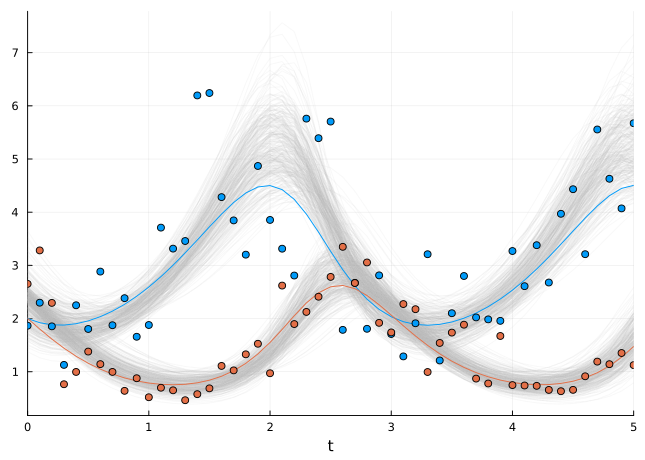

In [39]:
import Flux
using Turing: Variational
model = fitlv2(data_mat, prob)
q0 = Variational.meanfield(model)
advi = ADVI(10, 10_000) # first arg is the 

q = vi(model, advi, q0; optimizer=Flux.ADAM(1e-2))

function plot_predictions_vi(q, sol, data_mat)
    myplot = plot(; legend=false)
    z = rand(q, 300)
    for parr in eachcol(z)
        p = NamedTuple([:α, :β, :γ, :δ] .=> parr[2:5])
        u0 = parr[6:7]
        sol_p = solve(prob, Tsit5(); u0, p, saveat)
        plot!(sol_p; alpha=0.1, color="#BBBBBB")
    end

    # Plot simulation and noisy observations.
    plot!(sol; color=[1 2], linewidth=1)
    scatter!(sol.t, data_mat'; color=[1 2])
    return myplot
end

plot_predictions_vi(q, sol_true, data_mat)

The cool thing with VI that we can sample from the resulting `q` with
ease.

In [40]:
q isa MultivariateDistribution

true

In [41]:
rand(q)

7-element Vector{Float64}:
 0.3910702850249754
 1.8261988965103004
 1.169798842596696
 2.80613428184438
 0.8402820867003005
 2.313112765625009
 2.406422925384114

-   [Learn more on VI in turing
    here](https://turinglang.org/docs/tutorials/09-variational-inference/)
-   [VI in general
    here](https://mpatacchiola.github.io/blog/2021/01/25/intro-variational-inference.html)

# Infering functional forms

Up to now, we have been infering the value of the model’s parameters,
assuming that the structure of our model is correct. But this is very
idealistic, specifically in ecology. As a general trend, we have little
idea of how does e.g. [the functional response of a
species](https://en.wikipedia.org/wiki/Functional_response) look like.

What if instead of inferring parameter values, we could infer functional
forms, or components within our model for which we have little idea on
how to express it mathematically?

In Julia, we can do that.

To illustrate this, we’ll assume that we do not know the functional
response of both prey and predator, i.e. the terms `β * y` and `δ * x`.
Instead, we will parametrize this component in our DE model by a neural
network, which can be seen as a simple non-linear regressor dependent on
some extra parameters `p_nn`.

We then simply have to optimize those parameters, along with the other
model’s parameters!

Let’s get started. To make the neural network, we’ll use the deep
learning library `Lux.jl`, which is similar to `Flux.jl` but where
models are explicitly parametrized. This explicit parametrization makes
it simpler to integrate with an ODE model.

To make things simpler, we will define a single layer neural network

In [42]:
using Lux
Random.seed!(2)
rng = Random.default_rng()
nn_init = Lux.Chain(Lux.Dense(2,2, relu))
p_nn_init, st_nn = Lux.setup(rng, nn_init)

nn = StatefulLuxLayer(nn_init, st_nn)

StatefulLuxLayer{true}(
 Dense(2 => 2, relu), # 6 parameters 
) # Total: 6 parameters,
 # plus 0 states.

We use a `StatefulLuxLayer` to not having to carry around `st_nn`, a
struct containing states of a Lux model, which is essentially useless
for a multi-layer perceptron.

In [43]:
st_nn

NamedTuple()

We can now evaluate our neural network model as follows:

In [44]:
nn(u0, p_nn_init)

2-element Vector{Float64}:
 0.0
 0.0

instead of

In [45]:
nn_init(u0, p_nn_init, st_nn)

([0.0, 0.0], NamedTuple())

Let’s define a new parameter vectors, which will consist of the ODE
model parameters as well as the neural net parameters

In [46]:
pinit = ComponentArray(;σ = 0.3, α = 1., γ = 1.0, p_nn=p_nn_init)

ComponentVector{Float64}(σ = 0.3, α = 1.0, γ = 1.0, p_nn = (weight = [-1.0083649158477783 -0.7284937500953674; -1.219232201576233 0.4427390396595001], bias = [0.0; 0.0;;]))

> **Exercise: neural network-based Lotka-Volterra model**
>
> Define the neural network-based Lotka-Volterra model
>
> > **Solution**
> >
> > ``` julia
> > # function lotka_volterra_nn(du, u, p, t)
> > #     # Model parameters.
> > #     @unpack α, γ, p_nn = ...
> > #     ...
> > # end
> > ```

Let’s check our initial model predictions:


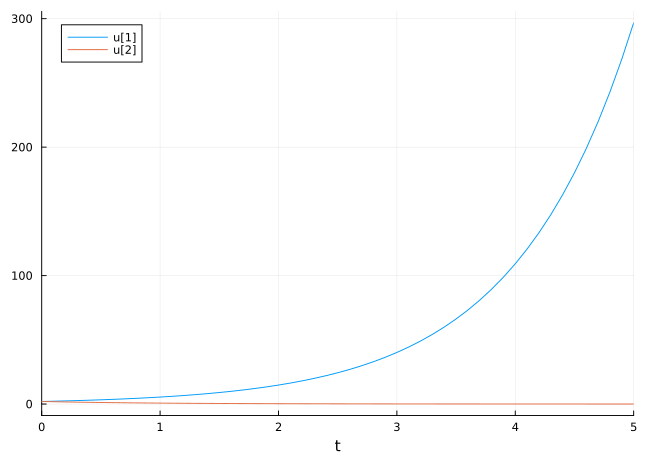

In [49]:
prob_nn = ODEProblem(lotka_volterra_nn, u0, tspan, pinit)
init_sol = solve(prob_nn, alg; saveat)
# Plot simulation.
plot(init_sol)

Now we can define our Turing Model. We’ll need to use a utility function
`vector_to_parameters` that reconstructs the neural network parameter
type based on a sampled parameter vector (taken from [this Turing
tutorial](https://quarto.org/docs/output-formats/html-code.html)). You
do not need to worry about this. Note that we could have used a
component vector, but for some reason this did not work at the time of
the writing of this tutorial…

In [50]:
using Functors # for the `fmap`
function vector_to_parameters(ps_new::AbstractVector, ps::NamedTuple)
    @assert length(ps_new) == Lux.parameterlength(ps)
    i = 1
    function get_ps(x)
        z = reshape(view(ps_new, i:(i + length(x) - 1)), size(x))
        i += length(x)
        return z
    end
    return fmap(get_ps, ps)
end

vector_to_parameters (generic function with 1 method)

In [51]:
# Create a regularization term and a Gaussian prior variance term.
sigma = 0.2

@model function fitlv_nn(data, prob)
    # Prior distributions.
    σ ~ InverseGamma(3, 0.5)
    α ~ truncated(Normal(1.5, 0.5); lower=0.5, upper=2.5)
    γ ~ truncated(Normal(3.0, 0.5); lower=1, upper=4)

    nparameters = Lux.parameterlength(nn)
    p_nn_vec ~ MvNormal(zeros(nparameters), sigma^2 * I)

    p_nn = vector_to_parameters(p_nn_vec, p_nn_init)

    # Simulate Lotka-Volterra model. 
    p = (;α, γ, p_nn)

    predicted = solve(prob, alg; p, saveat)

    # Observations.
    for i in 1:length(predicted)
        if all(predicted[i] .> 0)
            data[:, i] ~ MvLogNormal(log.(predicted[i]), σ^2 * I)
        end
    end

    return nothing
end


model = fitlv_nn(data_mat, prob_nn)

DynamicPPL.Model{typeof(fitlv_nn), (:data, :prob), (), (), Tuple{Matrix{Float64}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, ComponentVector{Float64, Vector{Float64}, Tuple{Axis{(σ = 1, α = 2, γ = 3, p_nn = ViewAxis(4:9, Axis(weight = ViewAxis(1:4, ShapedAxis((2, 2))), bias = ViewAxis(5:6, ShapedAxis((2, 1))))))}}}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(lotka_volterra_nn), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardODEProblem}}, Tuple{}, DynamicPPL.DefaultContext}(fitlv_nn, (data = [1.8655845948955276 2.298199048573464 … 4.071164055293614 5.672667515002083; 2.651867857608795 3.2812317734519048 … 1.351784872962806 1.1243450946947573], prob = ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, ComponentVector{Float64, Vector{Float64},

 12.103192 seconds (31.83 M allocations: 5.634 GiB, 3.78% gc time, 86.93% compilation time: <1% of which was recompilation)


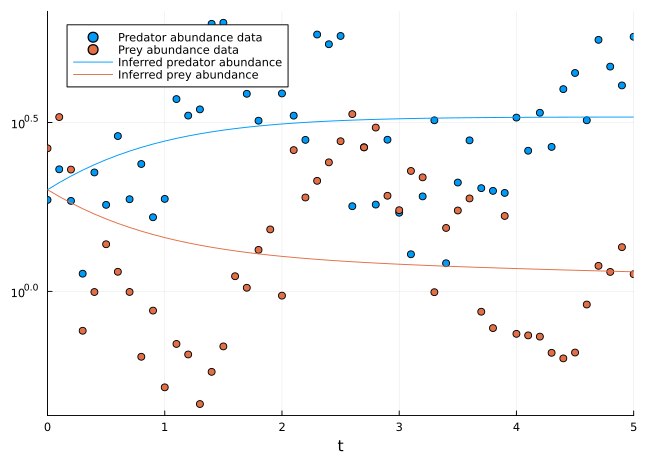

In [52]:
using Optimization, OptimizationOptimisers
@time map_res = maximum_a_posteriori(model, ADAM(0.05), maxiters=3000, initial_params=pinit)
pmap = ComponentArray(;σ=0, pinit...)
pmap .= map_res.values[:]
sol_map = solve(prob_nn, alg;p=pmap, saveat, tspan = (0, 10))
scatter(tsteps, data_mat',  color = [1 2], label=["Predator abundance data" "Prey abundance data"])
plot!(sol_map, color = [1 2], label=["Inferred predator abundance" "Inferred prey abundance"], yscale=:log10)

This seems to fail.

> **Exercise: take some initiative!**
>
> What could you do to improve the convergence of the optimization?
>
> > **Solution**
> >
> > ``` julia
> > #...
> > ```

Happy with the convergence? Now let’s investigate what did the neural
network learn!

In [55]:
function plot_func_resp(p, data)
    # plotting prediction of functional response
    u1 = range(minimum(data[1,:]), maximum(data[1,:]), length=100) 
    u2 = range(minimum(data[2,:]), maximum(data[2,:]), length=100) 
    u = hcat(u1,u2)

    func_resp = nn(u', p.p_nn)

    myplot1 = plot(u2,
                    - p_true.β .* u2; 
                    label="True functional form", 
                    xlabel="Predator abundance")
    plot!(myplot1,
                u2,
                - func_resp[1,:]; 
                color="#BBBBBB",
                label="Inferred functional form")

    myplot2 = plot(u1,
                    p_true.δ .* u2; 
                    legend=false, xlabel="Prey abundance")

    plot!(myplot2,
            u1,
            func_resp[2,:]; 
            color="#BBBBBB")

    myplot = plot(myplot1, myplot2)
    return myplot
end

plot_func_resp (generic function with 1 method)


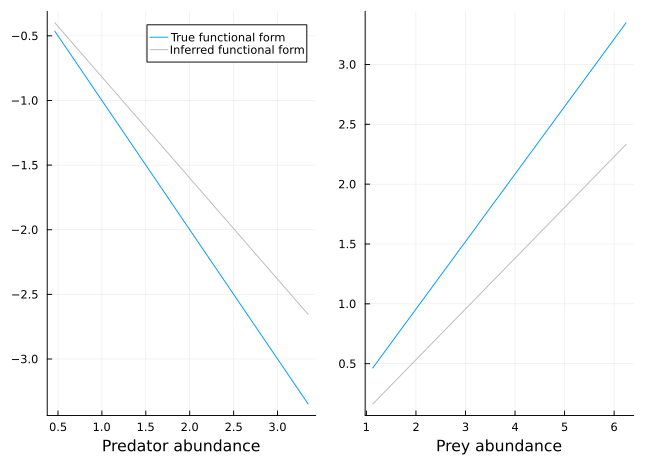

In [56]:
plot_func_resp(pmap, data_mat)

The neural network has well captured the functional forms of the
predator and prey.

> **Exercise: Probabilistic functional forms**
>
> Could you try to obtain a bayesian estimate of the functional forms
> with e.g. VI?
>
> > **Solution**
> >
> > ``` julia
> > #...
> > ```

This concludes this tutorial; I hope that it has given you plenty of
ideas for your future research projects!

## Resources

-   https://turinglang.org/docs/tutorials/10-bayesian-differential-equations/
-   https://turinglang.org/docs/tutorials/09-variational-inference/